In [1]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12



In [2]:

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


# Demo 1

In [3]:
import tensorflow as tf

sess=tf.Session()

node1 = tf.constant(3.0, dtype=tf.float32)
node2 = tf.constant(4.0) # also tf.float32 implicitly
print(node1)
print(node2)
node3 = tf.add(node1, node2)
sess.run(node3)

Tensor("Const:0", shape=(), dtype=float32)
Tensor("Const_1:0", shape=(), dtype=float32)


7.0

### Other operation

In [4]:
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2
print(f)

Tensor("add_1:0", shape=(), dtype=int32)


In [5]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [6]:
sess.close()

### Other way to run the graph

In [7]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
result

42

In [8]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    result = f.eval()
result

42

In [9]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)

42


In [10]:
sess.close()
result

42

## Managing graphs

In [11]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15

10
15


In [12]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


# Demo 2: Linear Regression:

## Predict the price of a house in California

### 1. Import data


In [13]:
import numpy as np
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt


housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]


X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")


print("X sahpe=", X.shape)
print("Y shape=", y.shape)

X sahpe= (20640, 9)
Y shape= (20640, 1)


Model of the linear regression

$$Y=W\cdot x+B$$

### linear least squares


$$[W| B]=(X^T\cdot X)^{-1}\cdot{X^T\cdot Y}$$


[[ -3.74651413e+01]
 [  4.35734153e-01]
 [  9.33829229e-03]
 [ -1.06622010e-01]
 [  6.44106984e-01]
 [ -4.25131839e-06]
 [ -3.77322501e-03]
 [ -4.26648885e-01]]
[-0.44051403]


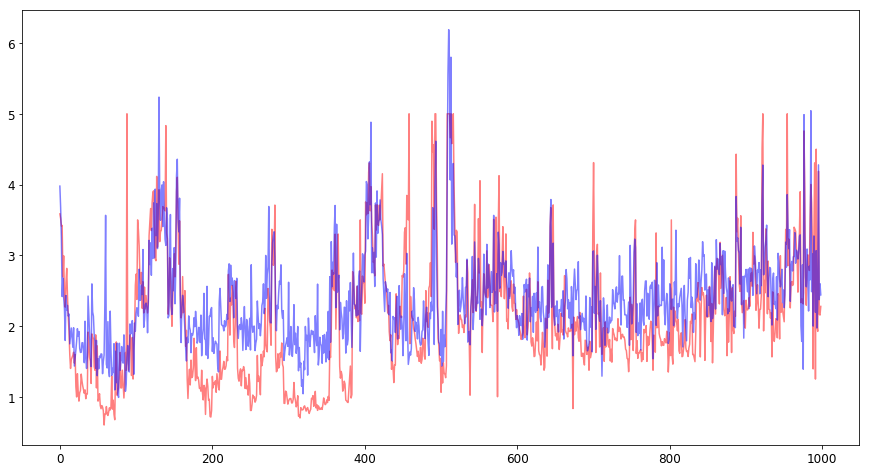

CPU times: user 544 ms, sys: 424 ms, total: 968 ms
Wall time: 776 ms


In [14]:
%%time

XT = tf.transpose(X)
WB = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    WB_value = WB.eval()
    y_value=y.eval() 

W=WB_value[0:-1]
B=WB_value[-1]
print(W)
print(B)


WBT=tf.transpose(WB)
y_pred=tf.matmul(WBT,XT)

with tf.Session() as sess:
    y_pred_value = y_pred.eval()
    y_value=y.eval() 

plt.figure(figsize=(15,8))
plt.plot(y_value[1:1000], 'r', label="Real value", alpha=0.5)
plt.plot(y_pred_value[0][1:1000], 'b', label="Predicted value", alpha=0.5)
plt.show()

### Compare with Numpy

[[ -3.69419202e+01]
 [  4.36693293e-01]
 [  9.43577803e-03]
 [ -1.07322041e-01]
 [  6.45065694e-01]
 [ -3.97638942e-06]
 [ -3.78654265e-03]
 [ -4.21314378e-01]]
[-0.43451375]


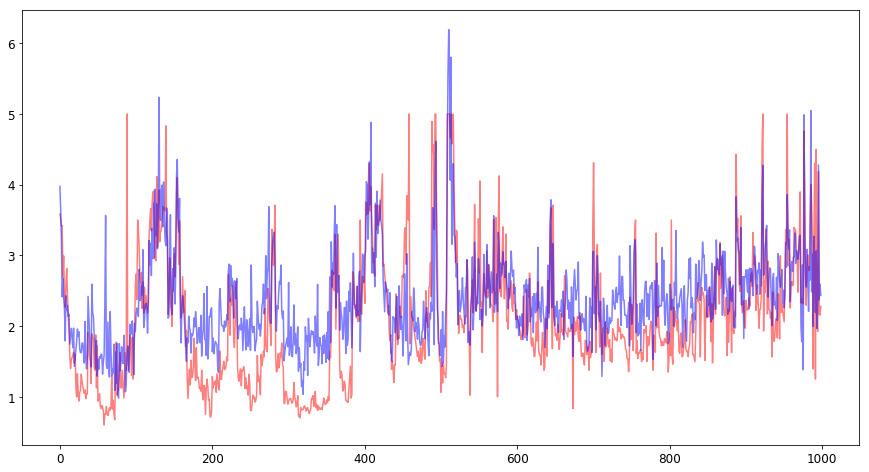

CPU times: user 464 ms, sys: 544 ms, total: 1.01 s
Wall time: 395 ms


In [15]:
%%time

X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
WB = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

W=WB[0:-1]
B=WB[-1]
print(W)
print(B)

y_pred=WB.T.dot(X.T)
plt.figure(figsize=(15,8))
plt.plot(y[1:1000], 'r', label="Real value", alpha=0.5)
plt.plot(y_pred[0,1:1000], 'b', label="Predicted value", alpha=0.5)
plt.show()

### Compare with scikit-learn


[[ -3.69419202e+01]
 [  4.36693293e-01]
 [  9.43577803e-03]
 [ -1.07322041e-01]
 [  6.45065694e-01]
 [ -3.97638942e-06]
 [ -3.78654265e-03]
 [ -4.21314378e-01]
 [ -4.34513755e-01]]


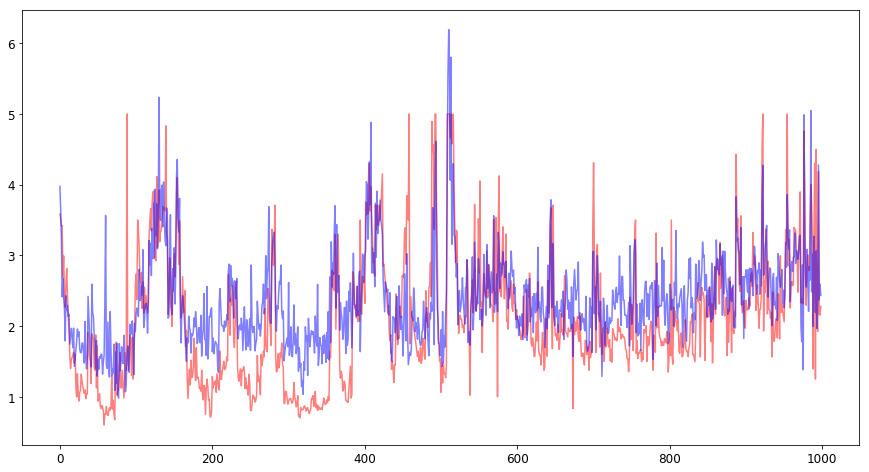

CPU times: user 720 ms, sys: 632 ms, total: 1.35 s
Wall time: 1.04 s


In [16]:
%%time
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

WB=np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T]
print(WB)
y_pred=lin_reg.predict(housing.data)

plt.figure(figsize=(15,8))
plt.plot(y[1:1000], 'r', label="Real value", alpha=0.5)
plt.plot(y_pred[1:1000], 'b', label="Predicted value", alpha=0.5)
plt.show()

### Train with batch-gradient descendent


$$Loss=\frac{1}{N}\sum (y_i-\widehat{y}_i)^2$$

In [17]:
reset_graph()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
x_train = np.c_[np.ones((m, 1)), scaled_housing_data]
y_train=housing.target.reshape(-1, 1)
sess.close()

Epoch 0 MSE = 9.16154
Epoch 100 MSE = 0.714501
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.555572
Epoch 400 MSE = 0.548812
Epoch 500 MSE = 0.543636
Epoch 600 MSE = 0.539629
Epoch 700 MSE = 0.536509
Epoch 800 MSE = 0.534068
Epoch 900 MSE = 0.532147


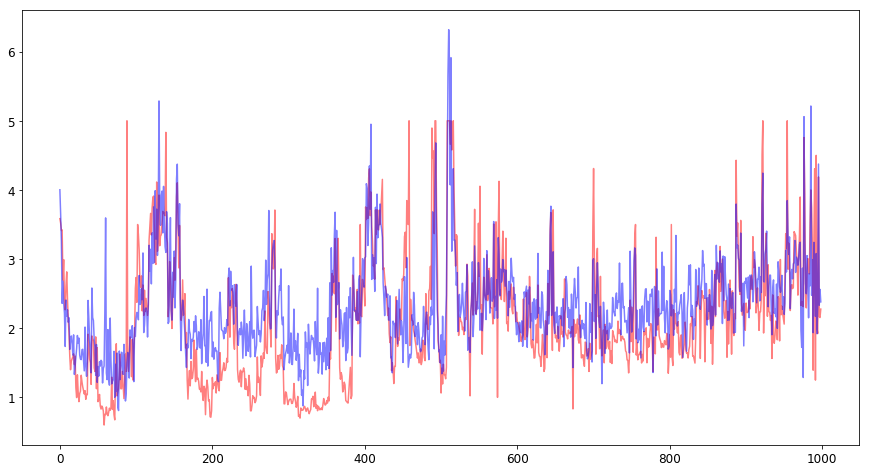

CPU times: user 2.53 s, sys: 372 ms, total: 2.9 s
Wall time: 1.21 s


In [18]:
%%time


sess=tf.Session()
# define parameters

LearningRate=0.01
iterations=1000

# define variables
X = tf.constant(x_train, dtype=tf.float32, name="X")
y = tf.constant(y_train, dtype=tf.float32, name="y")
WB = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="WB")
y_pred = tf.matmul(X, WB, name="predictions")

# define error and metrics
error = tf.square(y_pred - y)
mse = tf.reduce_mean(error, name="mse")
optimizer = tf.train.GradientDescentOptimizer(LearningRate) 
train = optimizer.minimize(mse)

init = tf.global_variables_initializer()

# run the graph
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(iterations):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(train)
    
    best_WB = WB.eval()
    y_pred_value=y_pred.eval()
    y_value=y.eval()
    
plt.figure(figsize=(15,8))
plt.plot(y_value[1:1000], 'r', label="Real value", alpha=0.5)
plt.plot(y_pred_value[1:1000], 'b', label="Predicted value", alpha=0.5)
plt.show()

### Saving and restoring the model



In [19]:
%%time


sess=tf.Session()
# define parameters

LearningRate=0.01
iterations=1000

# define variables
X = tf.constant(x_train, dtype=tf.float32, name="X")
y = tf.constant(y_train, dtype=tf.float32, name="y")
WB = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="WB")
y_pred = tf.matmul(X, WB, name="predictions")

# define error and metrics
error = tf.square(y_pred - y)
mse = tf.reduce_mean(error, name="mse")
optimizer = tf.train.GradientDescentOptimizer(LearningRate) 
train = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

# run the graph
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(iterations):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
        sess.run(train)
    
    best_WB = WB.eval()
    y_pred_value=y_pred.eval()
    y_value=y.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")


Epoch 0 MSE = 9.16154
Epoch 100 MSE = 0.714501
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.555572
Epoch 400 MSE = 0.548812
Epoch 500 MSE = 0.543636
Epoch 600 MSE = 0.539629
Epoch 700 MSE = 0.536509
Epoch 800 MSE = 0.534068
Epoch 900 MSE = 0.532147
CPU times: user 2.58 s, sys: 136 ms, total: 2.72 s
Wall time: 1.34 s


In [20]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_WB_restored = WB.eval() # not shown in the book

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


## Demo 3: Logistic regression

In [21]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<img width=60% src=./mnist.png >
<img width=60% src=./mnist2.png >


In [22]:
x = tf.placeholder(tf.float32, [None, 784])
y_true = tf.placeholder(tf.float32, [None, 10])

W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y_pred = tf.nn.softmax(tf.matmul(x, W) + b)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(y_pred), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)

sess = tf.InteractiveSession()

tf.global_variables_initializer().run()

for j in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_true: batch_ys})
    if j%100==0:
        print(j)


0
100
200
300
400
500
600
700
800
900


In [23]:
correct_prediction = tf.equal(tf.argmax(y_true,1), tf.argmax(y_pred,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_true: mnist.test.labels}))


0.9003


### COmplete code

In [24]:
x = tf.placeholder(tf.float32, [None, 784])
y_true = tf.placeholder(tf.float32, [None, 10])

W1 = tf.Variable(tf.zeros([784, 10]))
b1 = tf.Variable(tf.zeros([10]))

y_pred = tf.nn.softmax(tf.matmul(x, W1) + b1)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



sess = tf.InteractiveSession()

tf.global_variables_initializer().run()
acc=np.zeros(10000)
for j in range(10000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_true: batch_ys})
    acc[j]=accuracy.eval(feed_dict={x:batch_xs, y_true: batch_ys})
    if j%500==0:
        print('step %d, training accuracy %g' % (j, acc[j]))


step 0, training accuracy 0.41
step 500, training accuracy 0.54
step 1000, training accuracy 0.51
step 1500, training accuracy 0.66
step 2000, training accuracy 0.79
step 2500, training accuracy 0.71
step 3000, training accuracy 0.7
step 3500, training accuracy 0.81
step 4000, training accuracy 0.78
step 4500, training accuracy 0.74
step 5000, training accuracy 0.8
step 5500, training accuracy 0.81
step 6000, training accuracy 0.84
step 6500, training accuracy 0.79
step 7000, training accuracy 0.76
step 7500, training accuracy 0.79
step 8000, training accuracy 0.81
step 8500, training accuracy 0.85
step 9000, training accuracy 0.82
step 9500, training accuracy 0.74


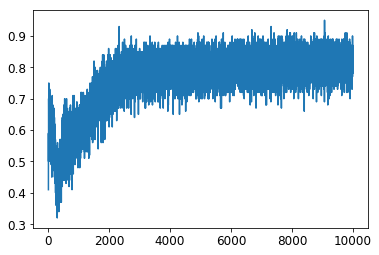

accuracy= 82.3499977589


In [25]:
plt.plot(acc)
plt.show()
print("accuracy=", 100*accuracy.eval(feed_dict={x: mnist.test.images, y_true: mnist.test.labels}))



# Demo 4

In [46]:
import tensorflow as tf

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_outputs = 10

In [47]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None, n_outputs), name="y")

In [48]:
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
print(logits.shape, y.shape)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.GradientDescentOptimizer(0.01)

training_op = optimizer.minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))


accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

(?, 10) (?, 10)


In [49]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 20
batch_size = 50
    
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                            y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.92 Val accuracy: 0.8948
1 Train accuracy: 0.92 Val accuracy: 0.9104
2 Train accuracy: 0.92 Val accuracy: 0.9212
3 Train accuracy: 0.88 Val accuracy: 0.9282
4 Train accuracy: 0.9 Val accuracy: 0.9316
5 Train accuracy: 0.88 Val accuracy: 0.9356
6 Train accuracy: 0.94 Val accuracy: 0.9396
7 Train accuracy: 0.9 Val accuracy: 0.9402
8 Train accuracy: 0.96 Val accuracy: 0.944
9 Train accuracy: 0.94 Val accuracy: 0.947
10 Train accuracy: 0.96 Val accuracy: 0.9502
11 Train accuracy: 1.0 Val accuracy: 0.9508
12 Train accuracy: 0.96 Val accuracy: 0.9532
13 Train accuracy: 0.98 Val accuracy: 0.955
14 Train accuracy: 0.98 Val accuracy: 0.9586
15 Train accuracy: 0.94 Val accuracy: 0.9592
16 Train accuracy: 0.96 Val accuracy: 0.9612
17 Train accuracy: 0.96 Val accuracy: 0.9616
18 Train accuracy: 0.98 Val accuracy: 0.9638
19 Train accuracy: 0.98 Val accuracy: 0.9638


In [50]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)
    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [45]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", np.argmax(mnist.test.labels[:20],1))

Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


# Demo 5

In [51]:

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')



## Network architecture

In [ ]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024]) ## 7x7 will be the size of the output image
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

## Train the model

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    acc=np.zeros(2000)
    for i in range(2000):
        batch = mnist.train.next_batch(50)
        if i % 200 == 0:
            train_accuracy = accuracy.eval(feed_dict={
              x: batch[0], y_true: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_true: batch[1], keep_prob: 0.5})
        acc[i]=accuracy.eval(feed_dict={x:batch[0], y_true: batch[1], keep_prob: 1.0})
    print('test accuracy %g' % accuracy.eval(feed_dict={
        x: mnist.test.images, y_true: mnist.test.labels, keep_prob: 1.0}))

## Example 2. Classifying large images using Inception v3.